# Emigration rates

At a high level:
- Use not-very-granular NIM estimates to work out emigration without many of the required stratifications.
- For the remaining stratifications, assume **emigrants** are like **immigrants.**

We do all operations at the **person** level, since that is the unit we have NIM estimates in.
Our final rate for household moves is therefore a rate of how many *people* should emigrate in
household moves.
In the simulation, we will sample households to emigrate until we hit our target # of people.

In [1]:
import pandas as pd, numpy as np
import seaborn as sns
from numpy.random import default_rng
import scipy.stats as stats

pd.set_option('display.min_rows', 20)

! whoami
! date

zmbc
Fri Oct 14 16:32:35 PDT 2022


In [2]:
acs = pd.read_hdf('../data/acs_2020_5yr_person.hdf', key='acs')

In [3]:
# Duplicate indices! In the future, should probably deal with this in download_acs!
# Filter to relevant columns to save memory
acs = acs[['SERIALNO', 'MIG', 'RELSHIPP', 'HISP', 'RAC1P', 'AGEP', 'SEX', 'NATIVITY', 'ST', 'PUMA', 'PWGTP']].reset_index(drop=True)

In [4]:
len(acs[['ST', 'PUMA']].drop_duplicates())

2351

## Do subtraction of immigration - NIM to get total number of emigrants in each broad race group

NIM estimates are not fully stratified. They are available stratified only by county, and stratified only by (broad categories) of race/ethnicity.
We've decided to use the latter, since it will have more interesting PRL implications.

In [5]:
acs['immigrant'] = (acs.MIG == 2).astype(int)
acs['gq_person'] = acs.RELSHIPP.isin([37, 38]).astype(int)
acs['ref_person'] = (acs.RELSHIPP == 20).astype(int)
acs['immigrant_ref_person'] = ((acs.ref_person == 1) & (acs.immigrant == 1)).astype(int)

In [6]:
acs['hispanic'] = (acs.HISP != 1).astype(int)
acs['white_alone'] = (acs.RAC1P == 1).astype(int)
acs['three_category_race_eth'] = np.where(acs.hispanic == 1, 'hispanic', np.where(acs.white_alone == 1, 'white_alone_not_hispanic', 'other'))

In [7]:
# Data source: https://www.census.gov/data/tables/time-series/demo/popest/2010s-national-detail.html
# Download from: https://www2.census.gov/programs-surveys/popest/tables/2010-2019/national/asrh/nc-est2019-compn.xlsx
# Values extracted for annual (1-year, same as the ACS immigration question) change: total, Hispanic, non-Hispanic White alone. The "other" category should = total - Hispanic - non-Hispanic White alone.
nim = pd.DataFrame([
    {'three_category_race_eth': 'hispanic', 'nim': 153_766},
    {'three_category_race_eth': 'white_alone_not_hispanic', 'nim': 64_469},
    {'three_category_race_eth': 'other', 'nim': 595_348 - 153_766 - 64_469},
])
nim

,three_category_race_eth,nim
0,hispanic,153766
1,white_alone_not_hispanic,64469
2,other,377113


In [8]:
immigration_by_race_eth = acs[acs.immigrant == 1].groupby('three_category_race_eth').PWGTP.sum().rename('immigration')

In [9]:
emigration_by_race_eth = immigration_by_race_eth.reset_index().merge(nim, on='three_category_race_eth').assign(emigration=lambda x: x.immigration - x.nim).set_index('three_category_race_eth')
emigration_by_race_eth

,immigration,nim,emigration
three_category_race_eth,,,
hispanic,467697,153766,313931
other,755459,377113,378346
white_alone_not_hispanic,619679,64469,555210


## Split that into a count by move type, according to the proportions of ACS immigrants in each category

In [10]:
acs['move_type'] = np.where(acs.immigrant == 1, np.where(acs.gq_person == 1, 'gq person', np.where(acs.SERIALNO.isin(acs[acs.immigrant_ref_person == 1].SERIALNO), 'household', 'non-reference person')), 'none')

In [11]:
type_proportions_by_race_eth = (acs[acs.immigrant == 1].groupby(['three_category_race_eth', 'move_type']).PWGTP.sum() / acs[acs.immigrant == 1].groupby(['three_category_race_eth']).PWGTP.sum())
emigration_by_race_eth_type = emigration_by_race_eth.emigration * type_proportions_by_race_eth
emigration_by_race_eth_type

three_category_race_eth   move_type           
hispanic                  gq person                21645.067120
                          household               136509.512062
                          non-reference person    155776.420817
other                     gq person                28330.162892
                          household               187687.829974
                          non-reference person    162328.007135
white_alone_not_hispanic  gq person                32817.364926
                          household               351591.457142
                          non-reference person    170801.177932
dtype: float64

## Prepare to distribute counts by additional demographics

In order to do this, we need to add simulation demographics columns to ACS.

In [12]:
# Based on code from vivarium_census_prl_synth_pop repository:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L105-L118

LATINO_VAR_MAP = {i: (1 if i == 1 else 0) for i in range(1, 25)}

RACE_ETHNICITY_VAR_MAP = {
    0: "Latino",
    1: "White",
    2: "Black",
    3: "AIAN",
    4: "AIAN",
    5: "AIAN",
    6: "Asian",
    7: "NHOPI",
    8: "Multiracial or Other",
    9: "Multiracial or Other",
}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L99-L106

acs["race_ethnicity"] = acs.HISP.map(LATINO_VAR_MAP)
acs.loc[acs.race_ethnicity == 1, "race_ethnicity"] = acs.loc[
    acs.race_ethnicity == 1
].RAC1P

# label each race/eth
acs.race_ethnicity = acs.race_ethnicity.map(RACE_ETHNICITY_VAR_MAP)

In [13]:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L120

SEX_VAR_MAP = {1: "Male", 2: "Female"}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L109

acs['sex'] = acs.SEX.map(SEX_VAR_MAP)

In [14]:
acs['born_in_us'] = acs.NATIVITY.map({1: 1, 2: 0})

In [15]:
acs['age_group'] = pd.cut(acs.AGEP, [0, 15, 18, 19, 20, 21, 22, 25, 30, 40, 50, 60, 70, 80, 100], right=False)

In [16]:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/6b89c9243035592d595a142390b83dedb567896b/src/vivarium_census_prl_synth_pop/utilities.py#L196-L216
# with modifications
def vectorized_choice(
    options,
    n_to_choose: int,
    rng,
    weights = None,
    additional_key = None,
):
    if weights is None:
        n = len(options)
        weights = np.ones(n) / n
    # for each of n_to_choose, sample uniformly between 0 and 1
    probs = rng.random(n_to_choose)

    # build cdf based on weights
    pmf = weights / weights.sum()
    cdf = np.cumsum(pmf)

    # for each p_i in probs, count how many elements of cdf for which p_i >= cdf_i
    # slow way
    # vect_find_index = np.vectorize(lambda p_i: (p_i >= cdf).sum())
    # chosen_indices = vect_find_index(probs)
    # fast way
    chosen_indices = np.searchsorted(cdf, probs, side='right')
    return np.take(options, chosen_indices)

In [17]:
def perturb_with_unconditional(df, acs_subset, acs_full, rng, columns, subset_prob=0.4, all_prob=0.1):
    perturb_propensity = pd.Series(rng.random(len(df)), index=df.index)
    subset_cutoff = (1 - all_prob - subset_prob)
    assert subset_cutoff >= 0
    all_cutoff = (1 - all_prob)

    subset_perturb_indices = df.index[(perturb_propensity > subset_cutoff) & (perturb_propensity <= all_cutoff)]
    donors_subset = acs_subset.loc[vectorized_choice(acs_subset.index, len(subset_perturb_indices), rng, weights=acs_subset.PWGTP), columns]
    donors_subset.index = subset_perturb_indices
    
    all_perturb_indices = df.index[perturb_propensity > all_cutoff]
    donors_all = acs_full.loc[vectorized_choice(acs_full.index, len(all_perturb_indices), rng, weights=acs_full.PWGTP), columns]
    donors_all.index = all_perturb_indices

    df.loc[subset_perturb_indices, columns] = donors_subset[columns]
    df.loc[all_perturb_indices, columns] = donors_all[columns]
    return df

In [18]:
def sample_with_perturbation(acs_df, full_acs, rng, n, perturb_col_suffix=''):
    # NOTE: Unlike in the simulation, we only ever sample with the sampling unit being a person.
    sample = acs_df.loc[vectorized_choice(acs_df.index, n, rng, weights=acs_df.PWGTP)].reset_index(drop=True)

    sample = perturb_with_unconditional(sample, acs_df, full_acs, rng, ['ST' + perturb_col_suffix, 'PUMA' + perturb_col_suffix])
    # We don't perturb race because it is unclear how to do this at the household level.
    # sample = perturb_with_unconditional(sample, acs_df, full_acs, rng, ['three_category_race_eth' + perturb_col_suffix, 'race_ethnicity' + perturb_col_suffix], subset_prob=0.2, all_prob=0.1)

    age_col = 'AGEP' + perturb_col_suffix
    lower_bound = np.where((sample.gq_person == 1) & (sample[age_col] >= 18), -1 * (sample[age_col] - 18), -1 * sample[age_col])
    mean = 0
    std = 10
    age_shift = stats.truncnorm(a=((lower_bound - mean) / std), b=np.inf, loc=mean, scale=std).rvs(random_state=rng)

    sample[age_col] += age_shift
    sample[age_col] = np.clip(sample[age_col], -np.inf, 125)
    
    sample['age_group' + perturb_col_suffix] = pd.cut(sample[age_col], [0, 15, 18, 19, 20, 21, 22, 25, 30, 40, 50, 60, 70, 80, 100], right=False)
    
    return sample

In [19]:
def sample_acs_move_type(acs_df, move_type, rng_seed=12345, n=350_000_000, perturb_col_suffix=''):
    acs_subset = acs_df[(acs_df.immigrant == 1) & (acs_df.move_type == move_type)]
    return sample_with_perturbation(acs_subset, acs_df, default_rng(rng_seed), n=n, perturb_col_suffix=perturb_col_suffix)

In [20]:
def sample_acs_at_risk(acs_df, move_type, rng_seed=12345, n=350_000_000, perturb_col_suffix=''):
    at_risk = acs_df[(acs_df.gq_person == (move_type == 'gq person'))]
    if move_type == 'non-reference person':
        at_risk = at_risk[at_risk.ref_person == 0]
    return sample_with_perturbation(acs_df, acs_df, default_rng(rng_seed), n=n, perturb_col_suffix=perturb_col_suffix)

In [21]:
def distribute_by_immigration_and_calculate_rate(emigration, distribute_by, acs_df, move_type, at_risk, stratification_columns=['three_category_race_eth', 'age_group', 'sex', 'race_ethnicity', 'born_in_us'], col_suffix=''):
    emigration_to_distribute = emigration[emigration.index.get_level_values('move_type') == move_type]

    distribution_proportions = distribute_by.groupby([col + col_suffix for col in stratification_columns]).size() / len(distribute_by)
    distribution_proportions.index.names = stratification_columns

    emigration_stratified_count = emigration_to_distribute * distribution_proportions
    assert np.all(emigration_stratified_count[emigration_stratified_count > 0].reset_index().groupby([c for c in stratification_columns if c != 'three_category_race_eth']).size() <= 1)
    emigration_stratified_count = emigration_stratified_count.rename('emigration').reset_index().groupby([c for c in stratification_columns if c != 'three_category_race_eth']).emigration.sum()

    denominators = acs_df[(acs_df.gq_person == (move_type == 'gq person'))].PWGTP.sum() * (at_risk.groupby([c for c in stratification_columns if c != 'three_category_race_eth']).size() / len(at_risk))

    return emigration_stratified_count, (emigration_stratified_count / denominators).rename('emigration_rate')

## Non-reference-person emigration rate

- With the count of non-reference-person emigrants:
  - Distribute that count of non-reference-person emigrants using age/sex/race/birthplace/PUMA? proportions among non-reference-person immigrants in ACS.
  - Divide each sub-count by the people in that age/sex/race/birthplace/PUMA? group in ACS to get the rate.
  - Sample individuals for emigration at that rate.

In [22]:
def display_sample_size(acs_df, move_type, stratification_columns=['age_group', 'sex', 'race_ethnicity', 'born_in_us'], col_suffix=''):
    acs_subset = acs_df[(acs_df.immigrant == 1) & (acs_df.move_type == move_type)]
    sample_size = acs_subset.groupby([col + col_suffix for col in stratification_columns]).size().rename('sample_size').reset_index()
    sample_size[['age_start', 'age_end']] = [[x.left, x.right] for x in sample_size['age_group' + col_suffix]]
    sample_size['age'] = np.average(sample_size[['age_start', 'age_end']], axis=1)

    g = sns.relplot(
        data=sample_size,
        x="age", y="sample_size",
        hue="race_ethnicity" + col_suffix,
        row="born_in_us" + col_suffix, col="sex" + col_suffix,
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )
    g.set(yscale="symlog")
    g.set(ylim=(0, None))
    return g

In [23]:
def display_emigration_rates(emigration_rates, name):
    emigration_rates = emigration_rates.rename(name).reset_index()
    emigration_rates[['age_start', 'age_end']] = [[x.left, x.right] for x in emigration_rates['age_group']]
    emigration_rates['age'] = np.average(emigration_rates[['age_start', 'age_end']], axis=1)
    
    sns.relplot(
        data=emigration_rates,
        x="age", y=name,
        hue="race_ethnicity",
        row="born_in_us", col="sex",
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )

In [24]:
def format_emigration_rates_for_file(emigration_rates, name):
    emigration_rates = emigration_rates.rename(name).reset_index()
    age_bound_cols = ['age_start', 'age_end']
    emigration_rates[age_bound_cols] = [[x.left, x.right] for x in emigration_rates['age_group']]
    emigration_rates = emigration_rates.drop(columns=['age_group']).rename(columns={'ST': 'state', 'PUMA': 'puma'})
    return emigration_rates[age_bound_cols + [c for c in emigration_rates.columns if c not in age_bound_cols]]

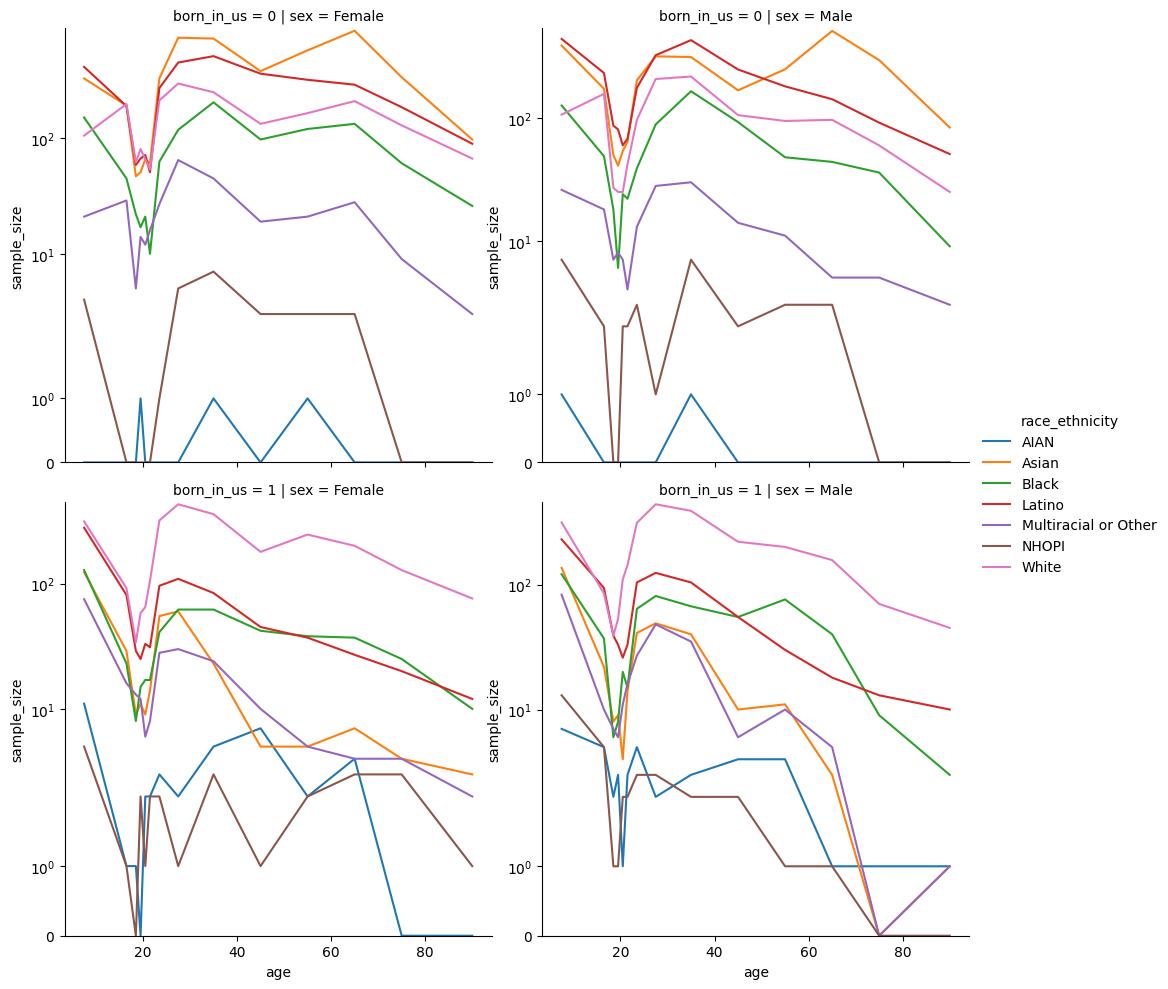

In [25]:
display_sample_size(acs, 'non-reference person')

In [26]:
%%time

distribute_by = sample_acs_move_type(acs, 'non-reference person')

CPU times: user 10h 4min 56s, sys: 24min 38s, total: 10h 29min 34s
Wall time: 10h 1min 43s


In [27]:
%%time

at_risk = sample_acs_at_risk(acs, 'non-reference person')

CPU times: user 10h 17min 49s, sys: 33min 15s, total: 10h 51min 5s
Wall time: 10h 14min 52s


In [28]:
%%time

nrp_emigration_counts, nrp_emigration_rates = distribute_by_immigration_and_calculate_rate(emigration_by_race_eth_type, distribute_by, acs, 'non-reference person', at_risk)

CPU times: user 2min 32s, sys: 41 s, total: 3min 12s
Wall time: 3min 12s


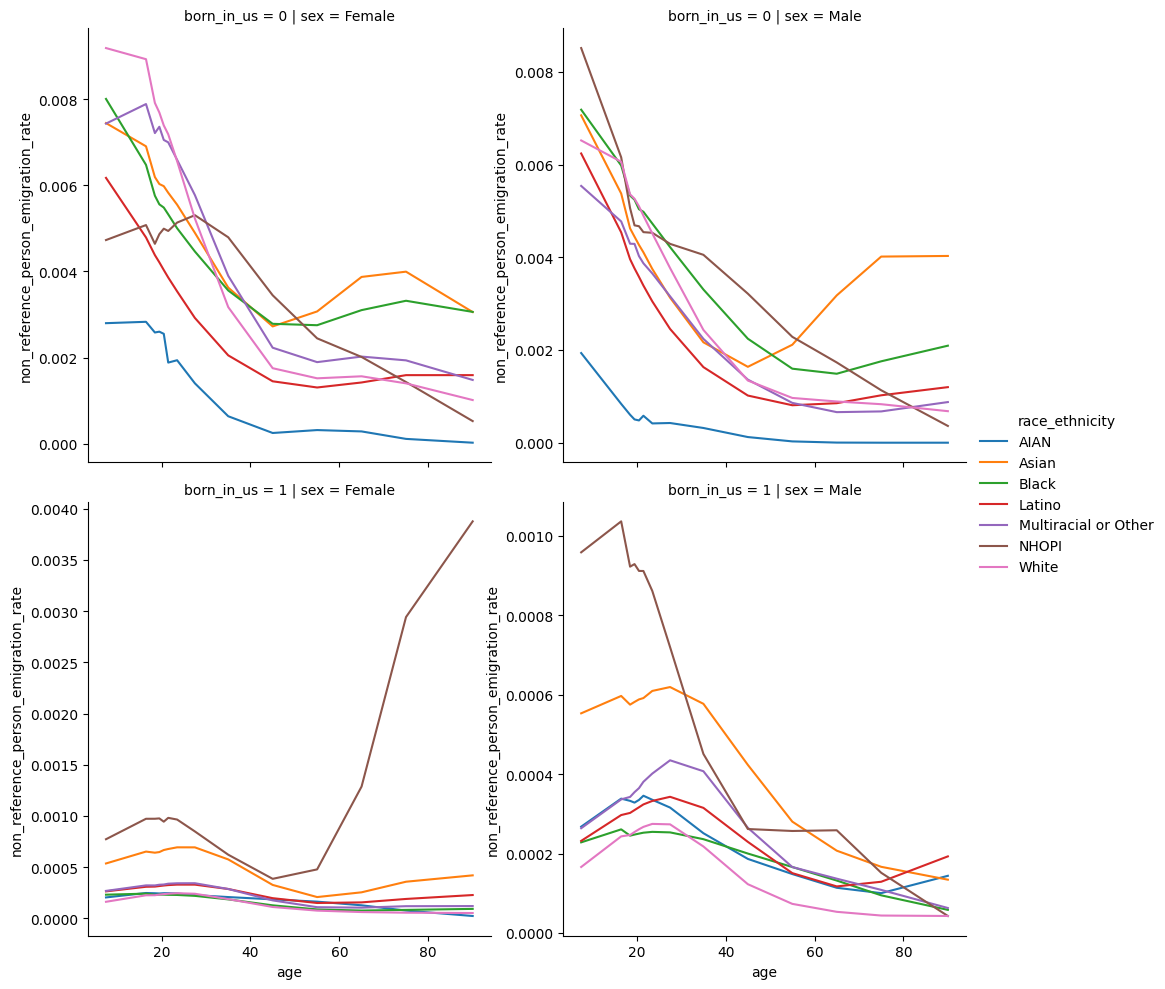

In [29]:
display_emigration_rates(nrp_emigration_rates, 'non_reference_person_emigration_rate')

In [30]:
%%time

nrp_emigration_counts_by_state, nrp_emigration_rates_by_state = distribute_by_immigration_and_calculate_rate(
    emigration_by_race_eth_type,
    distribute_by,
    acs,
    'non-reference person',
    at_risk,
    stratification_columns=['three_category_race_eth', 'age_group', 'sex', 'race_ethnicity', 'born_in_us', 'ST']
)

CPU times: user 2min 45s, sys: 46.9 s, total: 3min 32s
Wall time: 3min 32s


In [31]:
nrp_emigration_rates_by_state

age_group  sex     race_ethnicity  born_in_us  ST
[0, 15)    Female  AIAN            0           1     0.000375
                                               2     0.002435
                                               4     0.000951
                                               5     0.001784
                                               6     0.015927
                                               8     0.004485
                                               9     0.003058
                                               10    0.002548
                                               11    0.002548
                                               12    0.001515
                                                       ...   
[80, 100)  Male    White           1           46    0.000046
                                               47    0.000035
                                               48    0.000049
                                               49    0.000056
                    

In [32]:
nrp_emigration_rates_by_state.sort_values()

age_group  sex     race_ethnicity  born_in_us  ST
[60, 70)   Male    AIAN            0           29    0.0
                                               34    0.0
                                               33    0.0
                                               32    0.0
                                               31    0.0
                                               30    0.0
[50, 60)   Male    AIAN            0           9     0.0
[60, 70)   Male    AIAN            0           28    0.0
           Female  AIAN            0           50    0.0
           Male    AIAN            0           27    0.0
                                                    ... 
[70, 80)   Male    AIAN            0           11    NaN
[80, 100)  Female  AIAN            0           30    NaN
                                               38    NaN
                                               44    NaN
                                               50    NaN
           Male    AIAN            0  

In [33]:
len(nrp_emigration_rates_by_state[nrp_emigration_rates_by_state.isnull()])

83

In [34]:
len(nrp_emigration_rates_by_state[nrp_emigration_rates_by_state == np.inf])

123

In [35]:
len(nrp_emigration_rates_by_state[nrp_emigration_rates_by_state == 0])

338

In [36]:
nrp_emigration_rates_by_state = nrp_emigration_rates_by_state.replace(np.inf, np.nan).fillna(nrp_emigration_rates_by_state.median())
nrp_emigration_rates_by_state.sort_values()

age_group  sex     race_ethnicity  born_in_us  ST
[60, 70)   Male    AIAN            0           27    0.000000
[18, 19)   Male    AIAN            0           38    0.000000
                                               39    0.000000
                                               40    0.000000
                                               41    0.000000
                                               42    0.000000
[50, 60)   Male    AIAN            0           50    0.000000
[18, 19)   Male    AIAN            0           45    0.000000
[50, 60)   Male    AIAN            0           49    0.000000
[18, 19)   Male    AIAN            0           47    0.000000
                                                       ...   
[15, 18)   Female  NHOPI           0           2     0.074371
[80, 100)  Female  NHOPI           1           1     0.075026
[70, 80)   Female  NHOPI           1           1     0.077849
[19, 20)   Male    NHOPI           0           2     0.085472
[0, 15)    Female  N

In [37]:
format_emigration_rates_for_file(nrp_emigration_rates_by_state, 'non_reference_person_emigration_rate').to_csv('sim_inputs/non_reference_person_emigration_rates.csv', index=False)

## GQ person emigration rate

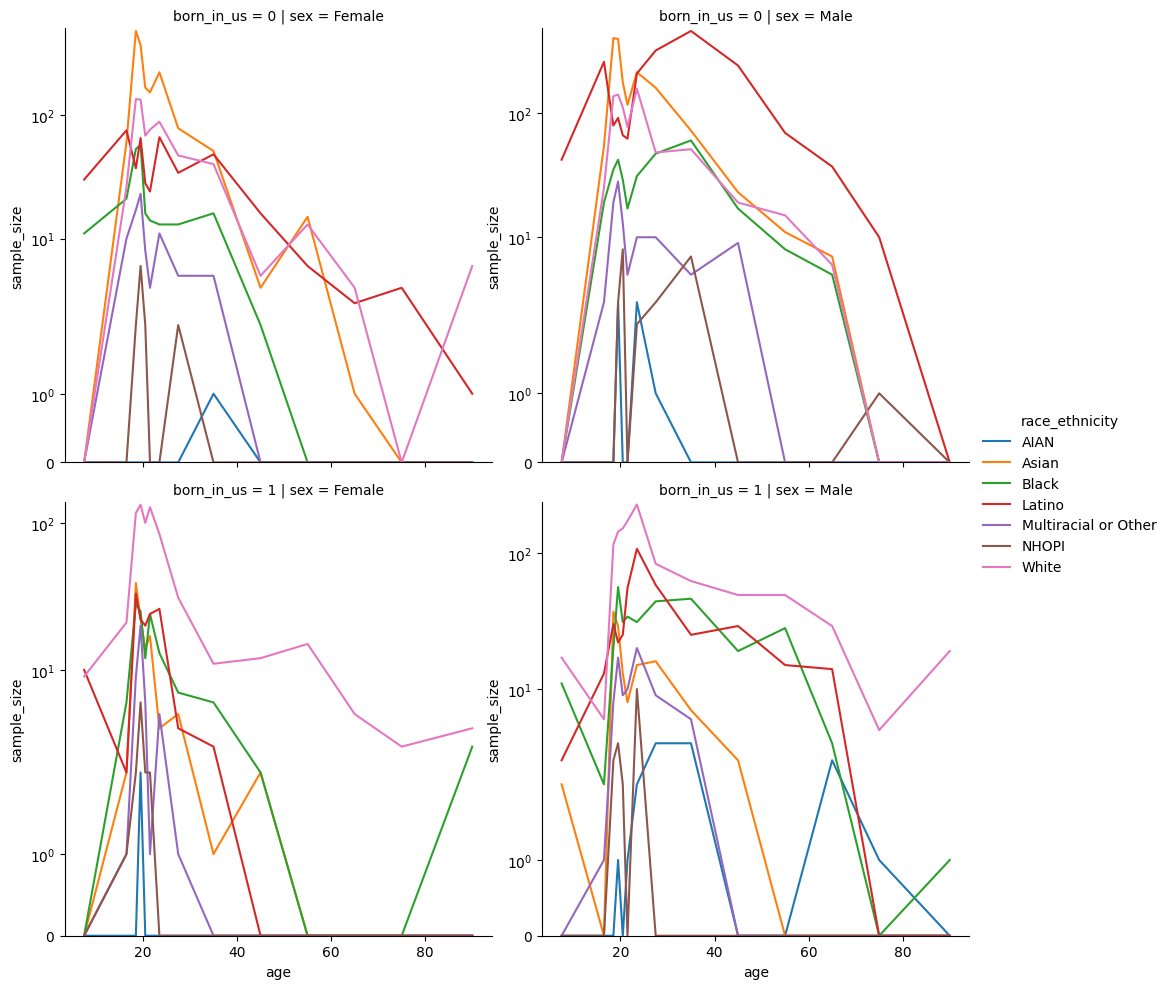

In [38]:
display_sample_size(acs, 'gq person')

In [39]:
%%time

distribute_by = sample_acs_move_type(acs, 'gq person')

CPU times: user 10h 1min 58s, sys: 33min 2s, total: 10h 35min
Wall time: 10h 54s


In [40]:
%%time

at_risk = sample_acs_at_risk(acs, 'gq person')

CPU times: user 10h 26min 44s, sys: 37min 32s, total: 11h 4min 16s
Wall time: 10h 24min 23s


In [41]:
%%time

gq_emigration_counts, gq_emigration_rates = distribute_by_immigration_and_calculate_rate(emigration_by_race_eth_type, distribute_by, acs, 'gq person', at_risk)

CPU times: user 2min 25s, sys: 40.3 s, total: 3min 5s
Wall time: 3min 5s


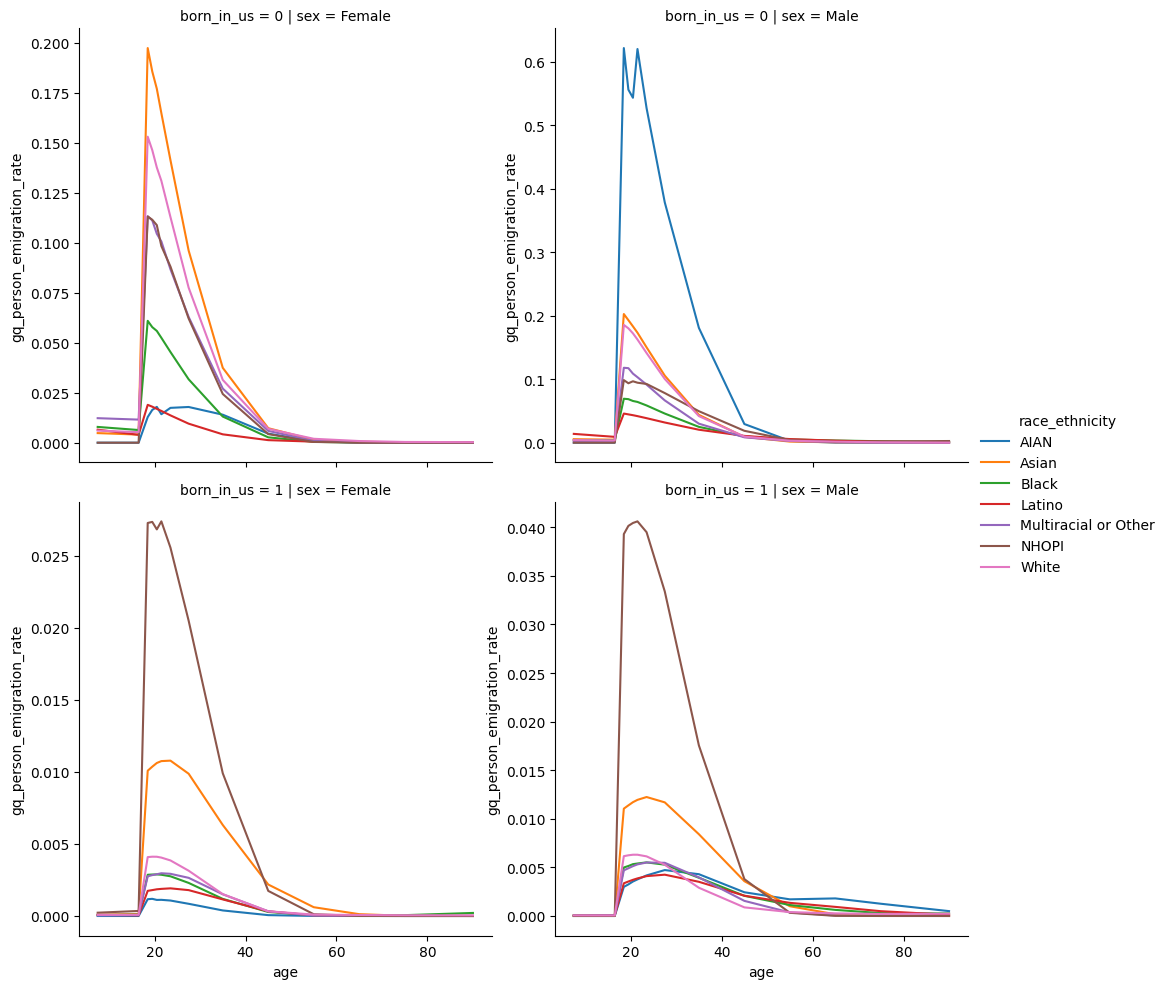

In [42]:
display_emigration_rates(gq_emigration_rates, 'gq_person_emigration_rate')

In [43]:
%%time

gq_emigration_counts_by_state, gq_emigration_rates_by_state = distribute_by_immigration_and_calculate_rate(
    emigration_by_race_eth_type,
    distribute_by,
    acs,
    'gq person',
    at_risk,
    stratification_columns=['three_category_race_eth', 'age_group', 'sex', 'race_ethnicity', 'born_in_us', 'ST']
)

CPU times: user 2min 39s, sys: 45.1 s, total: 3min 24s
Wall time: 3min 24s


In [44]:
gq_emigration_rates_by_state

age_group  sex     race_ethnicity  born_in_us  ST
[0, 15)    Female  AIAN            0           1     0.000000
                                               2     0.000000
                                               4     0.000000
                                               5     0.000000
                                               6     0.000000
                                               8     0.000000
                                               9     0.000000
                                               10    0.000000
                                               11    0.000000
                                               12    0.000000
                                                       ...   
[80, 100)  Male    White           1           46    0.000060
                                               47    0.000081
                                               48    0.000217
                                               49    0.000230
                    

In [45]:
gq_emigration_rates_by_state.sort_values()

age_group  sex     race_ethnicity  born_in_us  ST
[0, 15)    Female  AIAN            0           1     0.0
[80, 100)  Female  AIAN            1           15    0.0
                                               13    0.0
                                               12    0.0
                                               11    0.0
                                               10    0.0
                                               9     0.0
                                               8     0.0
                                               6     0.0
                                               16    0.0
                                                    ... 
[70, 80)   Male    AIAN            0           11    NaN
[80, 100)  Female  AIAN            0           30    NaN
                                               38    NaN
                                               44    NaN
                                               50    NaN
           Male    AIAN            0  

In [46]:
len(gq_emigration_rates_by_state[gq_emigration_rates_by_state.isnull()])

46

In [47]:
len(gq_emigration_rates_by_state[gq_emigration_rates_by_state == np.inf])

160

In [48]:
len(gq_emigration_rates_by_state[gq_emigration_rates_by_state == 0])

2158

In [49]:
gq_emigration_rates_by_state = gq_emigration_rates_by_state.replace(np.inf, np.nan).fillna(gq_emigration_rates_by_state.median())
gq_emigration_rates_by_state.sort_values()

age_group  sex     race_ethnicity  born_in_us  ST
[0, 15)    Female  AIAN            0           1      0.000000
[15, 18)   Male    AIAN            1           48     0.000000
                                               49     0.000000
                                               50     0.000000
                                               51     0.000000
                                               53     0.000000
                                               54     0.000000
                                               55     0.000000
                                               56     0.000000
                                               47     0.000000
                                                       ...    
[18, 19)   Male    AIAN            0           4      3.044732
[20, 21)   Male    AIAN            0           4      3.068126
[18, 19)   Male    AIAN            0           13     4.716235
[30, 40)   Male    AIAN            0           28     4.867764
[18, 

In [50]:
format_emigration_rates_for_file(gq_emigration_rates_by_state, 'gq_person_emigration_rate').to_csv('sim_inputs/group_quarters_person_emigration_rates.csv', index=False)

## Household emigration rate

- With the count of household emigrants:
  - Distribute that count of household emigrants using age/sex/race/birthplace/PUMA? proportions of household immigrants’ reference person in ACS.
  - Divide each sub-count by the people with a reference person with that age/sex/race/birthplace/PUMA? in ACS to get the person-level rate.
  - Multiply that rate by the current in-sim population size to get the desired count of emigrants, then sample households until you reach that desired count.

In [51]:
%%time

acs_with_reference_person_info = acs.merge(acs[acs.ref_person == 1][['SERIALNO', 'ST', 'PUMA', 'three_category_race_eth', 'AGEP', 'age_group', 'sex', 'race_ethnicity', 'born_in_us']], suffixes=('', '_ref_person'), on='SERIALNO')

CPU times: user 17.3 s, sys: 5.94 s, total: 23.3 s
Wall time: 23.2 s


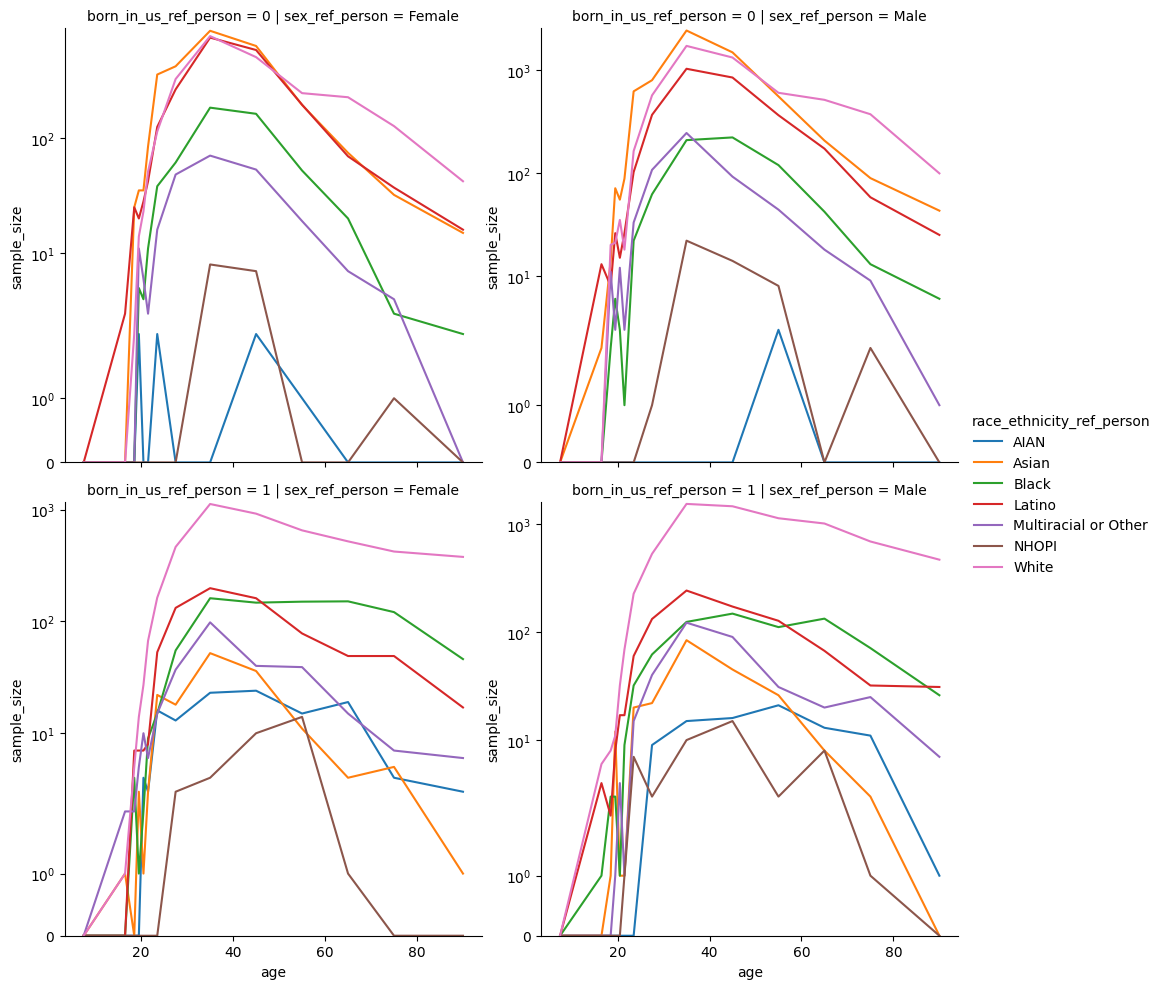

In [52]:
display_sample_size(acs_with_reference_person_info, 'household', col_suffix='_ref_person')

In [53]:
%%time

distribute_by = sample_acs_move_type(acs_with_reference_person_info, 'household', perturb_col_suffix='_ref_person')

CPU times: user 10h 7min 10s, sys: 33min 49s, total: 10h 40min 59s
Wall time: 10h 4min 49s


In [54]:
%%time

at_risk = sample_acs_at_risk(acs_with_reference_person_info, 'household', perturb_col_suffix='_ref_person')

CPU times: user 10h 30min 36s, sys: 38min 15s, total: 11h 8min 52s
Wall time: 10h 28min 52s


In [55]:
%%time

household_emigration_counts, household_emigration_rates = distribute_by_immigration_and_calculate_rate(
    emigration_by_race_eth_type,
    distribute_by,
    acs_with_reference_person_info,
    'household',
    at_risk,
    col_suffix='_ref_person'
)

CPU times: user 2min 30s, sys: 41.2 s, total: 3min 12s
Wall time: 3min 11s


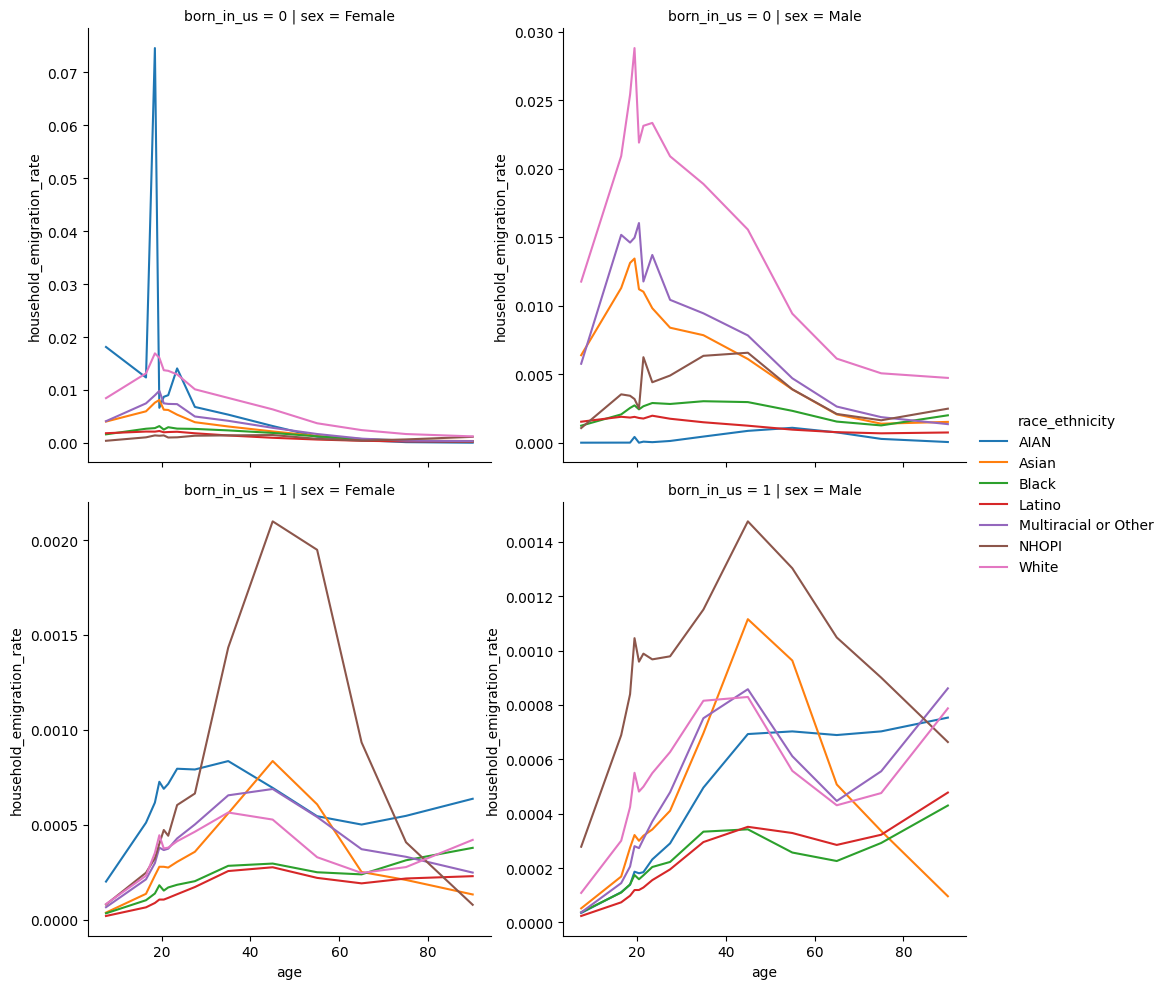

In [56]:
display_emigration_rates(household_emigration_rates, 'household_emigration_rate')

In [57]:
%%time

household_emigration_counts_by_state, household_emigration_rates_by_state = distribute_by_immigration_and_calculate_rate(
    emigration_by_race_eth_type,
    distribute_by,
    acs_with_reference_person_info,
    'household',
    at_risk,
    col_suffix='_ref_person',
    stratification_columns=['three_category_race_eth', 'age_group', 'sex', 'race_ethnicity', 'born_in_us', 'ST']
)

CPU times: user 2min 42s, sys: 46.9 s, total: 3min 29s
Wall time: 3min 29s


In [58]:
household_emigration_rates_by_state

age_group  sex     race_ethnicity  born_in_us  ST
[0, 15)    Female  AIAN            0           1          inf
                                               2          inf
                                               4     0.003764
                                               5          inf
                                               6     0.032063
                                               8          inf
                                               9          inf
                                               10         inf
                                               11         inf
                                               12    0.007734
                                                       ...   
[80, 100)  Male    White           1           46    0.000454
                                               47    0.000708
                                               48    0.001069
                                               49    0.001240
                    

In [59]:
household_emigration_rates_by_state.sort_values()

age_group  sex   race_ethnicity  born_in_us  ST
[15, 18)   Male  AIAN            0           33    0.0
[0, 15)    Male  AIAN            0           53    0.0
[25, 30)   Male  AIAN            0           40    0.0
[80, 100)  Male  AIAN            0           39    0.0
                                             42    0.0
                                             55    0.0
[15, 18)   Male  AIAN            0           42    0.0
                                             45    0.0
[19, 20)   Male  AIAN            0           6     0.0
[21, 22)   Male  AIAN            0           49    0.0
                                                  ... 
[80, 100)  Male  AIAN            0           45    NaN
                                             46    NaN
                                             47    NaN
                                             49    NaN
                                             50    NaN
                                             51    NaN
                 

In [60]:
len(household_emigration_rates_by_state[household_emigration_rates_by_state.isnull()])

432

In [61]:
len(household_emigration_rates_by_state[household_emigration_rates_by_state == np.inf])

2530

In [62]:
len(household_emigration_rates_by_state[household_emigration_rates_by_state == 0])

64

In [63]:
household_emigration_rates_by_state = household_emigration_rates_by_state.replace(np.inf, np.nan).fillna(household_emigration_rates_by_state.median())
household_emigration_rates_by_state.sort_values()

age_group  sex     race_ethnicity        born_in_us  ST
[0, 15)    Female  NHOPI                 0           30    0.000000
[70, 80)   Male    AIAN                  0           33    0.000000
[15, 18)   Male    AIAN                  0           45    0.000000
[0, 15)    Female  NHOPI                 1           56    0.000000
[20, 21)   Male    AIAN                  0           51    0.000000
                                                     12    0.000000
[0, 15)    Male    AIAN                  0           4     0.000000
                                                     6     0.000000
                                                     13    0.000000
                                                     17    0.000000
                                                             ...   
[20, 21)   Male    Asian                 0           50    0.518579
[21, 22)   Female  White                 0           5     0.523806
           Male    White                 0           22    0

In [64]:
format_emigration_rates_for_file(household_emigration_rates_by_state, 'household_emigration_rate').to_csv('sim_inputs/household_emigration_rates.csv', index=False)